<a href="https://colab.research.google.com/github/HazemHassine/Basira-lab/blob/master/FedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Understanding dataset in pytorch and the model and how is made**


In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=eeb2a37fa2a84069aad8c47fd91f03f56adee0758d4fdbc393c4e615477b32f7
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)




  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

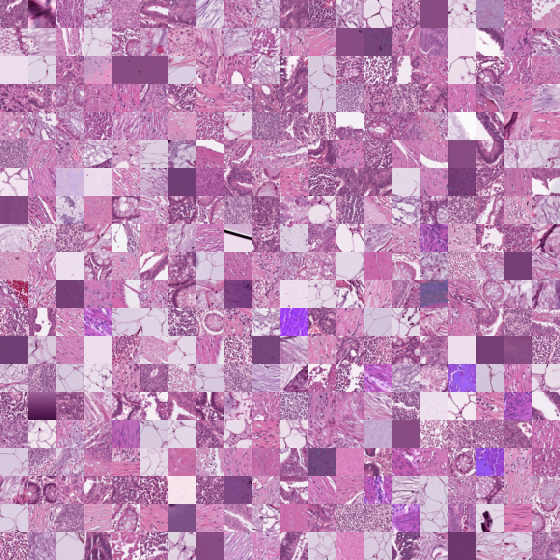

In [ ]:
# montage

train_dataset.montage(length=20)

In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:45<00:00,  4.26it/s]


In [ ]:
# evaluation

def test(split, model_1):
    model_1.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model_1(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
# test('train', model)
# test('test', model)
test('train',model)
test('test',model)

==> Evaluating ...
train  auc: 0.457  acc:0.088
test  auc: 0.459  acc:0.103


In [ ]:
plt.imshow(test_dataset[3][0].permute(1, 2, 0))

NameError: ignored

In [ ]:
print(test_dataset[50][0].shape)
print(test_dataset[50][0])

test_sample_out = model(test_dataset[50][0].unsqueeze(0))

torch.Size([3, 28, 28])
tensor([[[ 0.5686,  0.3882,  0.3647,  ...,  0.4275,  0.5137,  0.6157],
         [ 0.3569,  0.2784,  0.6078,  ...,  0.3647,  0.6000,  0.7333],
         [ 0.7255,  0.6471,  0.6549,  ...,  0.5137,  0.7490,  0.6706],
         ...,
         [ 0.6941,  0.6235,  0.7490,  ...,  0.5922,  0.5922,  0.6549],
         [ 0.3725,  0.5686,  0.6863,  ...,  0.6078,  0.4118,  0.6078],
         [ 0.6549,  0.7098,  0.5608,  ...,  0.7333,  0.7176,  0.6392]],

        [[ 0.2549,  0.0039,  0.0745,  ...,  0.0824,  0.1686,  0.3647],
         [ 0.0745, -0.0902,  0.3490,  ..., -0.0510,  0.2941,  0.4902],
         [ 0.5373,  0.3882,  0.3098,  ...,  0.1686,  0.4588,  0.3961],
         ...,
         [ 0.3412,  0.3098,  0.5529,  ...,  0.2706,  0.2235,  0.3098],
         [-0.1059,  0.1843,  0.3725,  ...,  0.2549,  0.0353,  0.3647],
         [ 0.3569,  0.4353,  0.1608,  ...,  0.4745,  0.4039,  0.3961]],

        [[ 0.5137,  0.3333,  0.3647,  ...,  0.3882,  0.4510,  0.5843],
         [ 0.3569,  0

In [ ]:
%debug
import copy
import pandas as pd
import pprint

class Server:
  def __init__(self, in_channels, n_classes, B, E, lr, K, IID=True):
    # initialize w_0 -> Initialize the global model.
    self.global_model = Net(in_channels=n_channels, num_classes=n_classes) 
    # initialize B, the local batch size
    self.B = B
    # intialize E, the numbeer of local epochs
    self.E = E
    # intialize the learning rate
    self.lr = lr
    # Take into account whether the data is IID or non IID.
    self.IID = IID
    # number of total clients K
    self.K = K
    self.w = dict()


  def Training_cycle(self, num_cycles, C=0.1):
    # intialize K, the Clients / No need for this
    # intialize P_k, the set of indexes of data points on client k
    # m = max(self.C * self.K, 1)    
    m = [i for i in range(1, max(int(np.floor(C*self.K)), 1)+1)]
    # get S_m[t], a random set of m clients
    S_m = [np.random.choice(m, size=int(C*len(m)), replace=False) for i in range(num_cycles)]
    print(f'm :{m} with a length of {len(m)}')
    # print(f'S_m :{S_m} with a length of {len(S_m)}')
    self.data_all = [i for i in range(len(data.DataLoader(dataset=train_dataset)))]
    P = dict()
    for t, clients in enumerate(S_m):
      P[f"{t}"] = dict()
      for k in clients:
        P[f'{t}'][f'{k}'] = np.random.choice(self.data_all, size=self.B)
    self.P = P
    # pprint.pprint(P)
    self.local_weights = dict()
    GLOBAL_MODEL = "models/global_model.pt"
    for t in tqdm(range(num_cycles)):
      self.w[t] = copy.deepcopy(self.global_model)
      self.local_weights = dict()
      for k in S_m[t]:
        #print(P)
        #print(type(P))
        #print(type(self.global_model))
        self.local_weights[k] = self.ClientUpdate(k=k, w=self.global_model,P=P,t=t) # , len(P[f"{t}"][f"{k}"])
      # m[t] is the total number of datapoints of all clients at this timepoint t
      self.global_model = self.aggregate_models(self.local_weights)
      print(self.global_model.state_dict().values())
      # print(t, torch.any(self.global_model.state_dict().values().isnan()))
      # print(type(self.global_model))
  # def average_models(self, local_models,P):
  #     # averaging the model should be in a seperate function
  #     print(len(local_models)) 
  #     # w[t+1] = (1/m[t]) * np.sum([len(S[t][k])*w[t+1][k] for k in S[t]])
  
  def aggregate_models(self, models):
    num_models = len(models)
    models = [*models.values()]
    # print(models)
    for model in models:
        model.eval()
  
    avg_model = self.global_model
    for key in avg_model.state_dict().keys():
        # print(key)
        for i in range(num_models):
            avg_model.state_dict()[key] += models[i].state_dict()[key]
        avg_model.state_dict()[key] = avg_model.state_dict()[key] / num_models
    if torch.tensor([avg_model.state_dict().values()]).isnan().any():
      print("nan values")
    else:
      print("no nan values")
    return avg_model
  
  def test_single_model(self, model_1, split="train"):
    print("testing model on train data")
    model_1.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model_1(inputs)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


  def ClientUpdate(self,k,w,P,t):
    # # initialize local model
    local_model = copy.deepcopy(w)
    # # Batches = split P_k into batches of size B
    # print(type(w))
    # print(type(local_model))
    local_optimizer = optim.SGD(local_model.parameters(), lr=self.lr, momentum=0.9)
    for e in range(self.E):
      for batch, targets in data.DataLoader(dataset=train_dataset, batch_size=10 ,sampler=data.SubsetRandomSampler(P[f"{t}"][f"{k}"])):
        local_optimizer.zero_grad()
        outputs = local_model(batch)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        loss.backward()
        local_optimizer.step()
    # print(f"\nTesting model number {k}\n")
    # self.test_single_model(local_model)
    # torch.save({"model":local_model, "n_k": 5}, f"model_{k}")
    return local_model

# train

server = Server(n_channels, n_classes, B=10,E=10,lr=0.01, K=200,IID=False)
server.Training_cycle(num_cycles=100, C=0.2)
server.test_single_model(server.global_model)

> <ipython-input-38-4d31fc2842d6>(73)aggregate_models()
     71             avg_model.state_dict()[key] += models[i].state_dict()[key]
     72         avg_model.state_dict()[key] = avg_model.state_dict()[key] / num_models
---> 73     if torch.tensor([*avg_model.state_dict().values()]).isnan().any():
     74       print("nan values")
     75     else:

ipdb> s
m :[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40] with a length of 40


  0%|          | 0/100 [00:02<?, ?it/s]


RuntimeError: ignored

In [ ]:
sum_local_epochs = server.E * 0.2 * server.K * 100 # 100 is the number of cycles
print(sum_local_epochs)

40000.0


In [ ]:
y_true = torch.tensor([])
y_score = torch.tensor([])
    
with torch.no_grad():
  for inputs, targets in data.DataLoader(dataset=train_dataset, batch_size=10 ,sampler=[1,85,185,842,74,22,74,25]):
    outputs = server.global_model(inputs)
    if task == 'multi-label, binary-class':
      targets = targets.to(torch.float32)
      outputs = outputs.softmax(dim=-1)
    else:
      targets = targets.squeeze().long()
      outputs = outputs.softmax(dim=-1)
      targets = targets.float().resize_(len(targets), 1)
    y_true = torch.cat((y_true, targets), 0)
    y_score = torch.cat((y_score, outputs), 0)

print(server.global_model.state_dict().values())
print(y_true)
print(y_score)

odict_values([tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [na

In [ ]:
!rm model*